In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
from glob import glob

# Define paths
img_dir = "/content/drive/MyDrive/human_ai_folder/processed_images"
txt_dir = "/content/drive/MyDrive/human_ai_folder/transcripts"

# Manual mapping for inconsistent names
name_correction = {
    "Constituciones": "Constituciones sinodales"
}

# Get all image file paths
image_files = sorted(glob(os.path.join(img_dir, "*.jpg")))

# Function to extract document name and page number from image filename
def extract_doc_and_page(image_filename):
    match = re.match(r"(.*)-page_(\d+)", image_filename)
    if match:
        doc_name, page_num = match.groups()

        # Correct document name if needed
        doc_name = name_correction.get(doc_name, doc_name)

        return doc_name, f"page{page_num}.txt"
    return None, None

# Create mapping between images and transcripts
image_text_pairs = []
for img_path in image_files:
    img_name = os.path.basename(img_path).replace(".jpg", "")
    doc_name, page_filename = extract_doc_and_page(img_name)

    if doc_name and page_filename:
        transcript_folder = os.path.join(txt_dir, f"transcript_{doc_name}")
        text_path = os.path.join(transcript_folder, page_filename)

        if os.path.exists(text_path):
            image_text_pairs.append((img_path, text_path))

# Check dataset size
print(f"Found {len(image_text_pairs)} image-text pairs")

# Display a few samples
for i, (img, txt) in enumerate(image_text_pairs[:5]):  # Show only 5 samples
    print(f"Sample {i+1}:")
    print(f"  Image Path    : {img}")
    print(f"  Transcript Path: {txt}")
    print("-" * 50)

Found 14 image-text pairs
Sample 1:
  Image Path    : /content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt
--------------------------------------------------
Sample 2:
  Image Path    : /content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_2.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page2.txt
--------------------------------------------------
Sample 3:
  Image Path    : /content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_3.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page3.txt
--------------------------------------------------
Sample 4:
  Image Path    : /content/drive/MyDrive/human_ai_folder/processed_images/Constituciones-page_1.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Constituciones sinodales

In [ ]:
import albumentations as A
import cv2
import numpy as np
from tqdm import tqdm

# Define augmentation pipeline
augmentations = A.Compose([
    A.Rotate(limit=3, p=0.5),  # Slight rotation
    A.RandomBrightnessContrast(p=0.5),  # Adjust brightness & contrast
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Inject noise
    A.MotionBlur(blur_limit=3, p=0.3),  # Simulate motion blur
])

# Define output directory for augmented images
augmented_data_dir = "/content/drive/MyDrive/human_ai_folder/augmented_images"
os.makedirs(augmented_data_dir, exist_ok=True)

num_augmentations = 10  # Generate 10 augmented versions per image
augmented_pairs = []

# Loop through original image-text pairs
for img_path, text_path in tqdm(image_text_pairs):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Save the original image (unchanged) in augmented dataset
    img_name = os.path.basename(img_path)
    orig_img_path = os.path.join(augmented_data_dir, img_name)
    cv2.imwrite(orig_img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    augmented_pairs.append((orig_img_path, text_path))

    # Generate multiple augmented images per original
    for i in range(1, num_augmentations + 1):
        augmented_img = augmentations(image=img)["image"]
        aug_img_name = img_name.replace(".jpg", f"_aug{i}.jpg")

        aug_img_path = os.path.join(augmented_data_dir, aug_img_name)
        cv2.imwrite(aug_img_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

        # Store mapping (augmented image -> original transcript)
        augmented_pairs.append((aug_img_path, text_path))

# Check dataset size
print(f"Total augmented dataset size: {len(augmented_pairs)} images")

<ipython-input-3-985981d802fa>:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Inject noise
100%|██████████| 14/14 [02:07<00:00,  9.13s/it]

Total augmented dataset size: 154 images


In [ ]:

for i, (img, txt) in enumerate(augmented_pairs[:5]):
    print(f"Augmented Sample {i+1}:")
    print(f"  Image Path    : {img}")
    print(f"  Transcript Path: {txt}")
    print("-" * 50)

Augmented Sample 1:
  Image Path    : /content/drive/MyDrive/human_ai_folder/augmented_images/Buendia-page_1.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt
--------------------------------------------------
Augmented Sample 2:
  Image Path    : /content/drive/MyDrive/human_ai_folder/augmented_images/Buendia-page_1_aug1.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt
--------------------------------------------------
Augmented Sample 3:
  Image Path    : /content/drive/MyDrive/human_ai_folder/augmented_images/Buendia-page_1_aug2.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Buendia/page1.txt
--------------------------------------------------
Augmented Sample 4:
  Image Path    : /content/drive/MyDrive/human_ai_folder/augmented_images/Buendia-page_1_aug3.jpg
  Transcript Path: /content/drive/MyDrive/human_ai_folder/transcripts/transcript_Bu

In [ ]:
!pip install transformers torch torchvision Pillow datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
import torch

class HDRDataset(Dataset):
    def __init__(self, image_text_pairs, processor,max_length=768):
        self.image_text_pairs = image_text_pairs
        self.processor = processor
        self.max_length=max_length

    def normalize_text(self, text):
        """Apply historical OCR normalization rules"""
        text = text.replace("ſ", "s")  # Long 's' → 's'
        text = text.replace("ç", "z")  # ç → z
        text = text.replace("q̄", "que")  # q-macron → que
        text = text.replace("u", "v") if "v" in text else text.replace("v", "u")  # u ↔ v
        text = text.translate(str.maketrans("áéíóú", "aeiou"))  # Remove accents (except ñ)
        return text



    def __len__(self):
        return len(self.image_text_pairs)


    def __getitem__(self, idx):
        img_path, text_path = self.image_text_pairs[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load text
        with open(text_path, "r", encoding="utf-8") as f:
            text = f.read().strip()

        text = self.normalize_text(text)


        # Process image and text
        encoding = self.processor(
            image,
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
            )

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),  # Image tensor
            "labels": encoding["labels"].squeeze(0),        # Tokenized text
            }



def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])

    labels = pad_sequence([item['labels'] for item in batch], batch_first=True, padding_value=-100)
    return {'pixel_values': pixel_values, 'labels': labels}

In [ ]:
from torchvision import transforms
class HDRProcessor:
    def __init__(self, tokenizer, image_size=(384, 384)):
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __call__(self, image, text, padding, truncation, max_length, return_tensors):
        image_tensor = self.transform(image)
        tokenized = self.tokenizer(
            text,
            padding=padding,
            truncation=truncation,
            max_length=max_length,
            return_tensors=return_tensors
        )
        return {
            "pixel_values": image_tensor,
            "labels": tokenized["input_ids"]
        }


In [ ]:
class CharTokenizer:
    def __init__(self, chars, max_length=512):
        self.special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
        self.vocab = {ch: idx + len(self.special_tokens) for idx, ch in enumerate(chars)}
        for idx, token in enumerate(self.special_tokens):
            self.vocab[token] = idx

        self.inv_vocab = {idx: tok for tok, idx in self.vocab.items()}
        self.pad_token_id = self.vocab["<pad>"]
        self.sos_token_id = self.vocab["<sos>"]
        self.eos_token_id = self.vocab["<eos>"]
        self.unk_token_id = self.vocab["<unk>"]
        self.max_length = max_length

    def encode(self, text):
        tokens = [self.sos_token_id]
        for ch in text:
            tokens.append(self.vocab.get(ch, self.unk_token_id))
        tokens.append(self.eos_token_id)
        return tokens

    def __call__(self, text, padding="max_length", truncation=True, max_length=None, return_tensors=None):
        max_len = max_length or self.max_length
        token_ids = self.encode(text)

        if truncation:
            token_ids = token_ids[:max_len]

        if padding == "max_length":
            pad_len = max_len - len(token_ids)
            token_ids += [self.pad_token_id] * pad_len

        if return_tensors == "pt":
            return {"input_ids": torch.tensor(token_ids, dtype=torch.long)}
        return {"input_ids": token_ids}

    def decode(self, token_ids):
        return "".join([self.inv_vocab.get(idx, "") for idx in token_ids if idx not in [self.pad_token_id, self.sos_token_id, self.eos_token_id]])

    def vocab_size(self):
        return len(self.vocab)


In [ ]:
from collections import Counter

def build_charset(image_text_pairs):
    all_chars = Counter()
    for _, text_path in image_text_pairs:
        with open(text_path, 'r', encoding='utf-8') as f:
            text = f.read()
            all_chars.update(text)
    return sorted(list(set(all_chars)))

In [ ]:
charset = build_charset(image_text_pairs)
tokenizer = CharTokenizer(chars=charset)

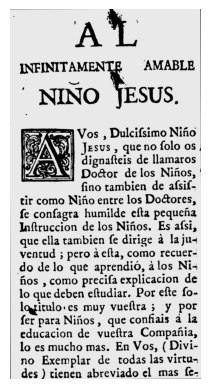

Extracted Text:
Al
INFINITAMENTE AMABLE
NIÑO JESUS.
A Vos, Dulcissimo Niño
JESUS, que no solo os
dignasteis de llamaros
Doctor de los Niños, 
sino también de assis-
tir como Niño entre los Doctores, 
se consagra humilde esta pequeña
Instrucción de los Niños. Es assi, 
que ella también se dirige a la ju-
ventud; pero a esta, como recuer-
do de lo que aprendió, a los Ni-
ños, como precisa explicacion de 
lo que deben estudiar. Por este so-
lo titulo es muy vuestra; y por
ser para Niños, que confiais a la
educacion de vuestra Compañia, 
lo es mucho mas. En Vos, (Divi-
no Exemplar de todas las virtu-
des) tienen abreviado el mas se-


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Select a random image-text pair
img_path, txt_path = random.choice(augmented_pairs)

# Display the image
img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")
plt.show()

# Read and print corresponding text
with open(txt_path, "r", encoding="utf-8") as f:
    text = f.read()
print(f"Extracted Text:\n{text}")

In [ ]:
tokenizer = CharTokenizer(charset)

# Encode a sample text
sample_text = "jig gvv kjhhi wet"
enc = tokenizer(sample_text, return_tensors="pt")
print("Encoded:", enc["input_ids"])

# Decode to verify
decoded = tokenizer.decode(enc["input_ids"].tolist())
print("Decoded:", decoded)

Encoded: tensor([ 1, 58, 57, 55,  6, 55, 69, 69,  6,  3, 58, 56, 56, 57,  6,  3, 53, 67,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,

In [ ]:
# Instantiate the dataset with augmented pairs and processor
dataset = HDRDataset(image_text_pairs=augmented_pairs, processor=HDRProcessor(tokenizer))

# Get a sample (e.g., sample 0)
sample = dataset[0]

# Print the output for inspection
print("Sample Output:")
print(f"Image Tensor Shape: {sample['pixel_values'].shape}")
print(f"Tokenized Labels (IDs): {sample['labels']}")

# Decode the label IDs back to text (for validation)
decoded_text = tokenizer.decode(sample['labels'].tolist())
print(f"Decoded Text: {decoded_text}")


Sample Output:
Image Tensor Shape: torch.Size([3, 384, 384])
Tokenized Labels (IDs): tensor([ 1, 25, 59,  5, 33, 38, 30, 33, 38, 33, 44, 25, 37, 29, 38, 44, 29,  6,
        25, 37, 25, 26, 36, 29,  5, 38, 33, 73, 39,  6, 34, 29, 43, 45, 43, 13,
         5, 25,  6, 46, 62, 66, 11,  6, 28, 69, 59, 51, 57, 66, 66, 57, 60, 62,
         6, 38, 57, 78, 62,  5, 34, 29, 43, 45, 43, 11,  6, 64, 69, 53,  6, 61,
        62,  6, 66, 62, 59, 62,  6, 62, 66,  5, 52, 57, 55, 61, 49, 66, 67, 53,
        57, 66,  6, 52, 53,  6, 59, 59, 49, 60, 49, 65, 62, 66,  5, 28, 62, 51,
        67, 62, 65,  6, 52, 53,  6, 59, 62, 66,  6, 38, 57, 78, 62, 66, 11,  6,
         5, 66, 57, 61, 62,  6, 67, 49, 60, 50, 57, 53, 61,  6, 52, 53,  6, 49,
        66, 66, 57, 66, 12,  5, 67, 57, 65,  6, 51, 62, 60, 62,  6, 38, 57, 78,
        62,  6, 53, 61, 67, 65, 53,  6, 59, 62, 66,  6, 28, 62, 51, 67, 62, 65,
        53, 66, 11,  6,  5, 66, 53,  6, 51, 62, 61, 66, 49, 55, 65, 49,  6, 56,
        69, 60, 57, 59, 52, 53,  6,

# Making the FCN encoder


### FCN Encoder with Convolutions, Depthwise Separable Convolutions, Dropout, and Normalization:


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCNEncoder(nn.Module):
    def __init__(self):
        super(FCNEncoder, self).__init__()

        # 18 convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)

        # Depthwise separable convolutions (12 layers)
        self.dw_conv1 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv4 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv5 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv6 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv7 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv8 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv9 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv10 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv11 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)
        self.dw_conv12 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, groups=16)

        # Instance Normalization
        self.instance_norm = nn.InstanceNorm2d(16)

        # Diffused Mix Dropout
        self.dropout = nn.Dropout2d(p=0.5)

    def forward(self, x):
        # Regular convolutions
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))

        # Depthwise separable convolutions
        x = F.relu(self.dw_conv1(x))
        x = F.relu(self.dw_conv2(x))
        x = F.relu(self.dw_conv3(x))
        x = F.relu(self.dw_conv4(x))
        x = F.relu(self.dw_conv5(x))
        x = F.relu(self.dw_conv6(x))
        x = F.relu(self.dw_conv7(x))
        x = F.relu(self.dw_conv8(x))
        x = F.relu(self.dw_conv9(x))
        x = F.relu(self.dw_conv10(x))
        x = F.relu(self.dw_conv11(x))
        x = F.relu(self.dw_conv12(x))

        # Apply instance normalization and dropout
        x = self.instance_norm(x)
        x = self.dropout(x)

        return x


### 2D positional encoding (for image sequencing)

In [ ]:
import torch
import math

class PositionalEncoding2D(nn.Module):
    def __init__(self, height, width, d_model):
        super(PositionalEncoding2D, self).__init__()
        self.height = height
        self.width = width
        self.d_model = d_model

        # Create positional encodings for rows and columns
        self.row_pos = torch.zeros(height, d_model // 2)
        self.col_pos = torch.zeros(width, d_model // 2)

        for pos in range(height):
            for i in range(d_model // 2):
                self.row_pos[pos, i] = math.sin(pos / (10000 ** (2 * i / d_model)))

        for pos in range(width):
            for i in range(d_model // 2):
                self.col_pos[pos, i] = math.cos(pos / (10000 ** (2 * i / d_model)))

    def forward(self):
        # Concatenate row and column positional encodings
        row_encoding = self.row_pos.unsqueeze(0).repeat(self.width, 1, 1).transpose(0, 1)  # height x width x d_model/2
        col_encoding = self.col_pos.unsqueeze(0).repeat(self.height, 1, 1)  # width x height x d_model/2

        return torch.cat([row_encoding, col_encoding], dim=-1)  # Return 2D positional encoding


In [ ]:
class FinalEncoder(nn.Module):
    def __init__(self, height, width, hidden_dim):
        super(FinalEncoder, self).__init__()
        self.fcn_encoder = FCNEncoder()  # Base FCN encoder
        self.positional_encoding = PositionalEncoding2D(height, width, hidden_dim)

    def forward(self, x):
        # Apply FCN encoder
        feature_map = self.fcn_encoder(x)  # Output: (batch_size, channels, height, width)

        # Add positional encoding to the feature map
        pos_enc = self.positional_encoding()
        feature_map = feature_map + pos_enc.unsqueeze(0)  # Adding 2D positional encoding

        return feature_map


In [ ]:
from torchvision import transforms
from PIL import Image
import torch

# Load and preprocess an image
image_path = "/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_2.jpg"  # Change to a valid image path
image = Image.open(image_path).convert("RGB")

# Match your HDRProcessor transform (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_tensor = transform(image).unsqueeze(0)  # Add batch dimension → (1, 3, 384, 384)

# Initialize the encoder
encoder = FCNEncoder()

# Run the image through the encoder
with torch.no_grad():
    output = encoder(image_tensor)

print("Input shape:", image_tensor.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([1, 3, 384, 384])
Output shape: torch.Size([1, 16, 384, 384])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, nhead, window_size=100):
        super().__init__()
        self.window_size = window_size
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=0.1, batch_first=True)

    def forward(self, x):
        B, T, C = x.size()
        causal_mask = torch.full((T, T), float("-inf"), device=x.device)
        for t in range(T):
            causal_mask[t, max(0, t - self.window_size):t + 1] = 0
        return self.attn(x, x, x, attn_mask=causal_mask)[0]

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model=256, nhead=4):
        super().__init__()
        self.self_attn = CausalSelfAttention(d_model, nhead)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=0.1, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_model, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, tgt, memory):
        tgt2 = self.self_attn(self.norm1(tgt))
        tgt = tgt + tgt2

        tgt2 = self.cross_attn(self.norm2(tgt), memory, memory)[0]
        tgt = tgt + tgt2

        tgt2 = self.ffn(self.norm3(tgt))
        tgt = tgt + tgt2
        return tgt

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=8, max_len=3000):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))  # learned positional encoding

        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, nhead)
            for _ in range(num_layers)
        ])

        self.output_proj = nn.Conv1d(d_model, vocab_size, kernel_size=1)

    def forward(self, tgt_ids, memory):
        x = self.embedding(tgt_ids) + self.pos_embedding[:, :tgt_ids.size(1), :]
        for layer in self.layers:
            x = layer(x, memory)

        # Convert to (B, C, T) for Conv1d
        logits = self.output_proj(x.transpose(1, 2)).transpose(1, 2)
        return logits


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DANModel(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, d_model):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vocab_proj = nn.Conv1d(d_model, vocab_size, kernel_size=1)

    def forward(self, images, tgt_input_ids, tgt_mask=None):
        # images: (B, 3, H, W)
        # tgt_input_ids: (B, T)

        # 1. Encode image
        encoder_output = self.encoder(images)  # (B, C, H', W')

        # Flatten encoder output (B, C, H, W) → (B, L, C)
        B, C, H, W = encoder_output.shape
        encoder_output_flat = encoder_output.view(B, C, H * W).permute(0, 2, 1)  # (B, L, C)

        # 2. Decode sequence
        decoder_output = self.decoder(
            tgt_input_ids,  # (B, T)
            encoder_output_flat,  # (B, L, C)
            tgt_mask=tgt_mask  # (T, T)
        )  # (B, T, d_model)

        # 3. Project to vocabulary
        logits = self.vocab_proj(decoder_output.transpose(1, 2))  # (B, vocab_size, T)
        logits = logits.transpose(1, 2)  # (B, T, vocab_size)
        return logits

    def generate(self, image, sos_token_id, eos_token_id, max_length=3000):
        # image: (1, 3, H, W)
        self.eval()
        with torch.no_grad():
            encoder_output = self.encoder(image)  # (1, C, H', W')
            B, C, H, W = encoder_output.shape
            encoder_output_flat = encoder_output.view(B, C, H * W).permute(0, 2, 1)  # (1, L, C)

            # Start with <sos>
            generated = torch.tensor([[sos_token_id]], dtype=torch.long, device=image.device)  # (1, 1)

            for t in range(max_length):
                tgt_mask = self.decoder.generate_square_subsequent_mask(generated.size(1)).to(image.device)
                decoder_output = self.decoder(generated, encoder_output_flat, tgt_mask=tgt_mask)
                logits = self.vocab_proj(decoder_output.transpose(1, 2)).transpose(1, 2)  # (1, T, vocab_size)

                next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(0)  # (1, 1)
                generated = torch.cat([generated, next_token], dim=1)

                if next_token.item() == eos_token_id:
                    break

        return generated[:, 1:]  # Exclude <sos>


In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
processor = HDRProcessor(tokenizer)
train_dataset = HDRDataset(augmented_pairs, processor=processor, max_length=512)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
model = DANModel(  # DANModel is our final encoder-decoder wrapper
    encoder=FinalEncoder(height=384, width=384, hidden_dim=256),
    decoder=TransformerDecoder(
        vocab_size=tokenizer.vocab_size(),
        d_model=256,
        num_layers=8,
        num_heads=4,
        ff_dim=256,
        dropout=0.1,
        max_len=512
    )
).to(device)


TypeError: TransformerDecoder.__init__() got an unexpected keyword argument 'num_heads'